# Projet 04 : integration sur maillage triangulaire

On considère une pièce mécanique découpée dans une plaque d'épaisseur constante selon $Oz$ et constituée d'un matériau parfaitement homogène. Le but du projet est d'estimer le moment d'inertie de la pièce autour de l'axe perpendiculaire à la pièce passant par l'origine du maillage.

Dans le cas d'un système à épaisseur constante,  on montre qu'une approche 2D est suffisante. On discrétise la surface projetée selon Oz en éléments finis à base de triangles jointifs.

![geometry](snap2.png)

La description d'un maillage en éléments finis se fait, de manière générale, par l'intermédiaire de deux tableaux, la table des coordonnées et la table de connectivité. La première contient les coordonnées des noeuds. La seconde table dite de connectivité associe à chaque élément $e$ la liste des NBN noeuds lui appartenant.

Le moment d'inertie, notée ci-après $I$, s'écrit comme une somme d'intégrales élémentaires sur chaque élément $e$:
\begin{equation}
I=\iint\limits_{D}\, (x^2+y^2)\, dx\, dy=\sum_{e} \iint\limits_{e}\,  (x^2+y^2)\, dx \, dy=\sum_{e} I_e
\end{equation}
Une estimation de l'intégrale élémentaire $I_e$ sur un élément donné $e$
est donnée par la relation : $I_e \approx (x_G^2+y_G^2) \; S_e$
où $S_e$ est la surface de l'élément $e$,  $X_G$ et $Y_G$ étant le centre de gravité du triangle
coincidant avec la moyenne arithmétique des positions des sommets. Dans la technique d'intégration
 numérique de type Newton-Cotes, cela revient à placer le point d'intégration au centre de l'élément.

Finalement, l'intégrale sur tout le domaine $D$ est obtenue après assemblage de toutes
les intégrales élémentaires $I_e$ :

\begin{equation}
I = \sum_{e} I_e
\end{equation}

L'implémentation du calcul d'inertie est donné dans la cellule ci-dessous. On a décidé d'intégrer les données et les calculs au sein d'une classe nommée `Fem`. La table des coordonnées et la table de connectivité sont lues dans un fichier et placées en mémoire (x, y et t). Différentes méthodes permettent les calculs de surface et de moment d'inertie, et l'affichage du maillage et des éléments.

On vous demande de compléter le code suivant à plusieurs endroits :
1. Fonction `__init__` : coder la lecture du fichier pour initialiser les listes `__x`, `__y` et `__t`.

__Indication__: ouvrir avec un éditeur de texte, le fichier 'disk_coarse.pro' pour comprendre sa structure.

2. Implémenter la fonction membre `__surfaces` qui retourne une liste des surfaces de chaque élément.
3. Implémenter la fonction `__centers` : cette fonction doit retourner une liste de tuples (xG, yG) correspondant aux coordonnées des  centres de gravité  de chaque triangle.
4. Implémenter la fonction `inertia` : calcul du moment d'inertie = somme (distance à l'axe^2 * surface)

455


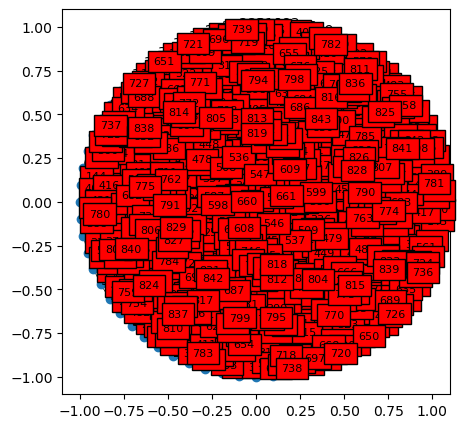

295 µs ± 6.42 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
surface :  3.136548490545945
838 µs ± 31.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Inertial momentum :  1.5633127034461467


In [1]:
%matplotlib inline
import sys
import numpy as np

import matplotlib.pyplot as plt 
import matplotlib.tri as tri
    
class Fem(object):
    
    def __init__(self, nom):
        self.__x = list()  # list of x 
        self.__y = list()  # list of y
        self.__t = list()  # list of triangle apexes (3 values) => list of lists
        
        try:
            with open(nom, 'r') as f:
                NP=int(f.readline())
                for i in range(NP):
                    line = f.readline()
                    [x, y] = line.split() # x and y of type str
                    self.__x.append(float(x))
                    self.__y.append(float(y))

                blank_line =  f.readline() # blank line after 1st part

                NE=int(f.readline()) 
                for ne in range(NE):
                    line = f.readline()
                    lst = line.split()
                    t=[int(e) for e in lst]
                    self.__t.append(t)
        except FileNotFoundError:
            print('error : mesh file not found')
            sys.exit(1)

    def __surfaces(self):
        """ Returns a list of the surface of each mesh element"""
        x=self.__x
        y=self.__y
        surf= list()
        
        for e in self.__t:
            i, j, k = e
            a = [x[j]-x[i], y[j]-y[i]]
            b = [x[k]-x[i], y[k]-y[i]]
            c = a[0]*b[1]-a[1]*b[0]
            surf.append(0.5*c)
            
        return surf
    
    def __centers(self):
        """ Returns a list of the tuples (xG, yG) corresponding to the center coordinates of each triangle element"""
        x=self.__x
        y=self.__y
        centers=list()
        
        for e in self.__t:
            i, j, k = e
            xG = 1/3 * (x[i]+x[j]+x[k])
            yG = 1/3 * (y[i]+y[j]+y[k])
            centers.append((xG, yG))
            
        return centers
    
    def num_points(self):
        return len(self.__x)
    
    def surface(self):
        """ Compute the total surface """
        return sum(self.__surfaces())

    def inertia(self): 
        """ Compute the moment of inertia"""
        squared_dist = [coord[0]**2+coord[1]**2 for coord in self.__centers()]

        I0 = 0
        for e in zip(self.__surfaces(), squared_dist):
            Se, d_sq = e[0], e[1] 
            I0 += Se * d_sq
        return I0
    
    def drawmesh(self): 
        x=self.__x
        y=self.__y
        t=self.__t
        
        triang = tri.Triangulation(x, y, t)
        plt.figure(figsize=(5, 5))
        plt.triplot(triang, lw=0.5, color='black')
        plt.plot(x, y, 'o')
        
        for i, (xi, yi) in enumerate(zip(x,y)):
            plt.text(xi, yi, str(i))
            
        for nt, (xi,yi) in enumerate(self.__centers()):
            plt.text(xi,yi, str(nt), bbox=dict(facecolor='red', alpha=1), size=8)
        
        plt.savefig('snap.png')
        plt.savefig('snap.pdf')
        plt.show()
 
if __name__ == "__main__":
    
    fem=Fem('disk_fine.pro')    
    print(fem.num_points())
    fem.drawmesh()

    %timeit S=fem.surface()
    S=fem.surface()
    print("surface : ", S)
    %timeit I=fem.inertia()
    I=fem.inertia()
    print("Inertial momentum : ", I)

Afin d'obtenir une vitesse plus rapide, nous devrions vectoriser le code, en remplaçant les boucles `for` par des tableaux numpy. 

Un exemple de cette vectorisation est la fonction `numpy.cross`, qui peut calculer le produit croisé de plusieurs vecteurs et renvoie un tableau contenant tous les résultats (voir l'exemple ci-dessous).

In [2]:
x = np.array([[1,2], [4,5], [7, 8]])
y = np.array([[4,5], [1,2], [6, 2]])
print(x.shape)
print(20*'-')
print(y.shape)
print(np.cross(x, y))

(3, 2)
--------------------
(3, 2)
[ -3   3 -34]


Le code de la classe `Fem` a été copié dans la cellule ci-dessous pour repartir sur de bonnes bases. Dans la méthode `__init__()`, les listes x et y sont remplacées par un `ndarray` (2 x Nx). De même, la liste des listes t est remplacée par un tableau (Nt x 3). Le code pour calculer les surfaces de chaque élément de manière vectorisée est donné. Ce que vous devez faire est le suivant :

1. Comprendre le fonctionnement du code de la méthode `__surfaces()`.
2. Écrire la fonction `__centers()`.
3. Écrire la fonction `num_points()`.
4. Ecrivez les fonctions `surface()` et `inertia()` (1 ligne chacune !)
5. Effectuer des tests de performance et les comparer aux résultats précédents

In [3]:
#%matplotlib inline
import sys
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.tri as tri
    
class Fem(object):
        
    def __init__(self, nom):
        x = list()  # list of x 
        y = list()  # list of y
        t = list()  # list of triangle apexes (3 values)
        
        try:
            with open(nom, 'r') as f:
                NP=int(f.readline())
                for i in range(NP):
                    line = f.readline()
                    [xi, yi] = line.split() # xi and yi of type str
                    x.append(float(xi))
                    y.append(float(yi))
                self.__xy = np.asarray([x,y])
                print(self.__xy.shape)
                print('-----------')
                
                blank_line =  f.readline() # blank line after 1st part

                NE=int(f.readline()) 
                for ne in range(NE):
                    line = f.readline()
                    lst = line.split()
                    ti=[int(e) for e in lst]
                    t.append(ti)
                self.__t = np.asarray(t)
                #print(self.__t)
                #print('-----------')
        except FileNotFoundError:
            print('error : mesh file not found')
            sys.exit(1)
            
    def __surfaces(self):
        """ Returns a ndarray of the surface of each mesh element"""
        xy = self.__xy
        t  = self.__t
        
        # Px are 2 x Nt arrays
        # Pi corresponds to the coordinates of the first apexes of all triangles
        # Pj corresponds to the coordinates of the second apexes of all triangles, etc...
        Pi = xy[:, t[:, 0]]
        Pj = xy[:, t[:, 1]] 
        Pk = xy[:, t[:, 2]]
        
        AB = Pj-Pi
        AC = Pk-Pi
        surf = 0.5 * np.cross(AB.T, AC.T)    # surf is a 1 x Nt array containing the surface of each triangle
        return surf
    
    def __centers(self):
        """ Returns a ndarray with 2 columns corresponding to the center coordinates of each triangle element"""
        xy =self.__xy
        t  =self.__t
           
        Pi=xy[:, t[:, 0]]
        Pj=xy[:, t[:, 1]] 
        Pk=xy[:, t[:, 2]]
        return (Pi+Pj+Pk)/3
    
    def num_points(self):
        return self.__xy.shape[1]
    
    def surface(self):
        """ Compute the total surface """
        return np.sum(self.__surfaces())

    def inertia(self): 
        """ Compute the moment of inertia"""
        #print((self.__centers()))
        #print('------------')
        #print(np.square(self.__centers()))
        #print('------------')
        #print( self.__surfaces())
        #print('============')
        RG_sq=np.sum(np.square(self.__centers()), axis=0)        
        return np.sum(RG_sq* self.__surfaces())
    
    def drawmesh(self): 
        x=self.__xy[0]
        y=self.__xy[1]
        t=self.__t
        
        triang = tri.Triangulation(x, y, t)
        plt.figure(figsize=(5, 5))
        plt.triplot(triang, lw=0.5, color='black')
        plt.plot(x, y, 'o')
        
        for i, [xi, yi] in enumerate(self.__xy):
            plt.text(xi, yi, str(i))
            
        for nt, [xi,yi] in enumerate(self.__centers()):
            plt.text(xi,yi, str(nt), bbox=dict(facecolor='red', alpha=1), size=8)
        
        plt.savefig('snap.png')
        plt.savefig('snap.pdf')
        plt.show()
 
if __name__ == "__main__":
    
    fem=Fem('disk_fine.pro')    
    print(fem.num_points())
    #fem.drawmesh()

    %timeit S=fem.surface()
    S=fem.surface()
    print("surface : ", S)
    %timeit I=fem.inertia()
    I=fem.inertia()
    print("Inertial momentum : ", I)

(2, 455)
-----------
455
65.1 µs ± 422 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
surface :  3.1365484905459393
123 µs ± 280 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Inertial momentum :  1.5633127034461463
